In [1]:
# %tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)

from tensorflow.keras import layers
import matplotlib.pyplot as plt
import matplotlib.pylab as plb
import numpy as np
import pandas as pd
from keras.layers import Input, Dense, Activation, Flatten, Conv2D, Lambda, MaxPooling2D, Dropout
from keras.utils import print_summary
from keras import models
from keras import layers
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.applications import VGG16
from keras_preprocessing.image import ImageDataGenerator
from scipy import pi


2.1.0


Using TensorFlow backend.


In [2]:
trainDF = pd.read_csv('/home/jupyter/Project/train.txt', sep=" ", header=None)
trainDF.columns = ['Images', 'SteeringAngle'] 
trainDF['SteeringAngle'] = trainDF['SteeringAngle'] * (pi / 180)

testDF = pd.read_csv('/home/jupyter/Project/test.txt', sep=" ", header=None)
testDF.columns = ['Images', 'SteeringAngle'] 

datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=40,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest',
            validation_split=0.25)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator=datagen.flow_from_dataframe(
dataframe=trainDF,
directory="/home/jupyter/Project/train/",
x_col="Images",
y_col="SteeringAngle",
subset="training",
batch_size=100,
seed=42,
shuffle=False,
class_mode="raw",
target_size=(200,66))

validation_generator = datagen.flow_from_dataframe(
dataframe=trainDF,
directory="/home/jupyter/Project/train/",
x_col="Images",
y_col="SteeringAngle",
subset="validation",
batch_size=100,
seed=42,
shuffle=False,
class_mode="raw",
target_size=(200,66))


Found 27342 validated image filenames.
Found 9113 validated image filenames.


In [3]:
from keras.regularizers import l2

def VGG_DataAug(width, height, depth):

    conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(height, width, depth))

    model = models.Sequential()
    model.add(conv_base)
    conv_base.trainable = False
    model.add(layers.Flatten())

    model.add(Dense(1164, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(10, activation='relu'))    
    model.add(Dense(1, activation='linear'))

    return model


In [4]:
NUM_EPOCHS = 30

model = VGG_DataAug(width=66, height=200, depth=3)
print (model.summary())

model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-4), loss="mse")

filepath = "/home/jupyter/Project/VGG/VGG_DA_Chekpoints/VGG_DA_weights.{epoch:02d}-{val_loss:.2f}.h5"
checkpoint = ModelCheckpoint(filepath, monitor="val_loss", mode="min", save_best_only=True, verbose=1)

history = model.fit(
                train_generator,
                steps_per_epoch=329,
                epochs=NUM_EPOCHS,
                validation_data=validation_generator,
                validation_steps=37,
                callbacks=[checkpoint])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 6, 2, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 6144)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1164)              7152780   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1164)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               116500    
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 50)               

/home/jupyter/.local/lib/python3.5/site-packages/keras/engine/saving.py:165: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '


329/329 [==============================] - 240s 731ms/step - loss: 0.1750 - val_loss: 0.0030

Epoch 00002: val_loss improved from 0.00361 to 0.00304, saving model to /home/jupyter/Project/VGG/VGG_DA_Chekpoints/VGG_DA_weights.02-0.00.h5
Epoch 3/30
329/329 [==============================] - 237s 721ms/step - loss: 0.2023 - val_loss: 1.7051e-05

Epoch 00003: val_loss improved from 0.00304 to 0.00002, saving model to /home/jupyter/Project/VGG/VGG_DA_Chekpoints/VGG_DA_weights.03-0.00.h5
Epoch 4/30
329/329 [==============================] - 237s 721ms/step - loss: 0.2265 - val_loss: 0.0017

Epoch 00004: val_loss did not improve from 0.00002
Epoch 5/30
329/329 [==============================] - 236s 719ms/step - loss: 0.2080 - val_loss: 0.0022

Epoch 00005: val_loss did not improve from 0.00002
Epoch 6/30
329/329 [==============================] - 237s 721ms/step - loss: 0.1944 - val_loss: 0.0018

Epoch 00006: val_loss did not improve from 0.00002
Epoch 7/30
329/329 [=========================

/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


avg_train_loss: 0.19190431875454264
avg_val_loss: 0.7804554499551766
difference: -0.588551131200634


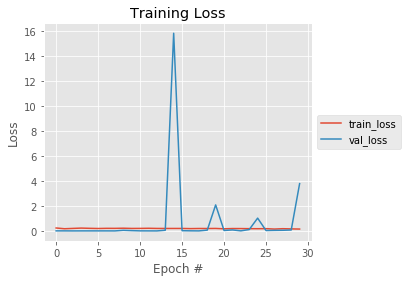

In [6]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, NUM_EPOCHS), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, NUM_EPOCHS), history.history["val_loss"], label="val_loss")
plt.title("Training Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
# https://stackoverflow.com/questions/4700614/how-to-put-the-legend-out-of-the-plot
ax = plt.subplot(111)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

avg_train_loss = sum(history.history["loss"])/NUM_EPOCHS
avg_val_loss = sum(history.history["val_loss"])/NUM_EPOCHS

print("avg_train_loss: " + str(avg_train_loss))
print("avg_val_loss: " + str(avg_val_loss))
print("difference: " + str(avg_train_loss - avg_val_loss))

In [17]:
from keras.models import load_model

test_generator=test_datagen.flow_from_dataframe(
dataframe=testDF,
directory="/home/jupyter/Project/test/",
x_col="Images",
# y_col="SteeringAngle",
y_col=None,    
batch_size=100,
seed=42,
shuffle=False,
class_mode=None,
target_size=(200, 66))

filepath = "/home/jupyter/Project/VGG/VGG_DA_Chekpoints/VGG_DA_weights.01-0.00.h5"

model.load_weights(filepath)


predictions = model.predict(test_generator)
print('Predictions: ', predictions.shape)

Found 8951 validated image filenames.
Predictions:  (8951, 1)


In [18]:
import pandas as pd

Images = testDF['Images']
preds = predictions
actual = testDF['SteeringAngle']

df_preds = pd.DataFrame(Images)
df_preds['Actual Steering Angle'] = (actual * (pi / 180))
df_preds['Predicted Steering Angle'] = preds
df_preds.rename(columns = {0:'Images'}, inplace = True) 

df_preds['MAE'] = 0

for i in range(len(df_preds)):
  df_preds.iloc[i, -1] = abs(df_preds.iloc[i, 1] - df_preds.iloc[i, 2])

mae_sum = 0
for i in range(len(df_preds)):
    mae_sum += df_preds.iloc[i, -1]
    
print("mae_sum: " + str(mae_sum))    
MAE = mae_sum / len(df_preds)
print("len(df_preds): " + str(len(df_preds)))
print("MAE: " + str(MAE))

mae_sum: 1967.5350901132474
len(df_preds): 8951
MAE: 0.21981176294416796


In [19]:
df_preds[8900:]

,Images,Actual Steering Angle,Predicted Steering Angle,MAE
8900,45355.jpg,0.103847,0.001870,0.101977
8901,45356.jpg,0.100356,0.003533,0.096824
8902,45357.jpg,0.093201,0.005445,0.087756
8903,45358.jpg,0.089710,0.008536,0.081174
8904,45359.jpg,0.086219,0.007598,0.078621
8905,45360.jpg,0.080983,0.005176,0.075807
8906,45361.jpg,0.074002,0.006343,0.067659
8907,45362.jpg,0.074002,0.008182,0.065820
8908,45363.jpg,0.066846,0.010162,0.056684
8909,45364.jpg,0.063355,0.008220,0.055135
